In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = True))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.9197530864197531, Loss: 0.3794514338175456
Checkpoint 200, Accuracy: 0.9691358024691358, Loss: 0.20632475393789787
Checkpoint 300, Accuracy: 0.9691358024691358, Loss: 0.17809219713564273
Checkpoint 400, Accuracy: 0.9629629629629629, Loss: 0.18083890279134116
Checkpoint 500, Accuracy: 0.9567901234567902, Loss: 0.1836075782775879


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [0.2612225  0.73417896 0.0045985 ]
[1. 0. 0.] <-> [0.95631045 0.03364114 0.01004845]
[1. 0. 0.] <-> [0.94753385 0.04056492 0.01190123]
[1. 0. 0.] <-> [0.95679736 0.026042   0.01716068]
[1. 0. 0.] <-> [0.8805121  0.01370923 0.10577873]
[1. 0. 0.] <-> [0.95467967 0.01865822 0.02666208]
[1. 0. 0.] <-> [0.95813763 0.03116024 0.01070204]
[0. 0. 1.] <-> [0.19946672 0.00325237 0.79728085]
[1. 0. 0.] <-> [0.9466976  0.02636095 0.02694145]
[1. 0. 0.] <-> [0.93748707 0.0490033  0.01350967]
[1. 0. 0.] <-> [0.8755975  0.01878121 0.10562134]
[1. 0. 0.] <-> [0.62322986 0.02088104 0.35588902]
[1. 0. 0.] <-> [0.9086455  0.02594585 0.06540862]
[1. 0. 0.] <-> [0.9531114  0.03721301 0.0096756 ]
[1. 0. 0.] <-> [0.93801045 0.05282929 0.00916023]
[1. 0. 0.] <-> [0.96280843 0.01678532 0.02040625]
[1. 0. 0.] <-> [0.8020529  0.18276909 0.01517793]
[1. 0. 0.] <-> [0.9525651  0.02540357 0.02203143]
[0. 1. 0.] <-> [0.09614214 0.9023995  0.00145837]
[0. 0. 1.] <-> [0.11560524 0.00345883 0.88093597]


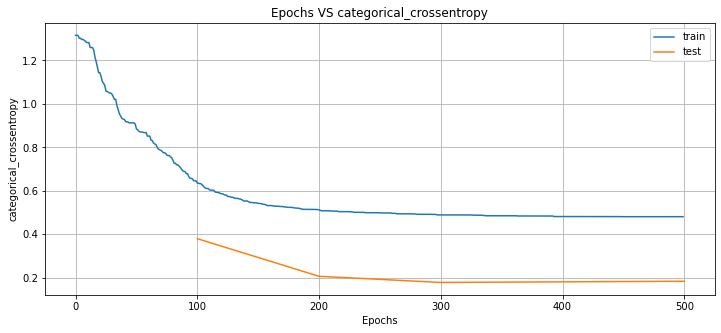

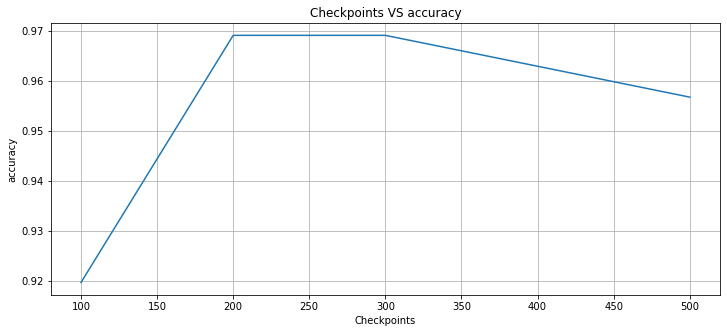

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9197530864197531, 'mean_square_error': 0.19190030607016167, 'categorical_crossentropy': 0.3794514338175456, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 12, 'tn_hit': 20, 'fn_hit': 1}, 1: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 7}, 2: {'tp_hit': 10, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 5}}, 'checkpoint': 100} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.0928218302341994, 'categorical_crossentropy': 0.20632475393789787, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 5, 'tn_hit': 27, 'fn_hit': 0}, 1: {'tp_hit': 14, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.08193766168382906, 'categorical_crossentropy': 0.17809219713564273, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 5, 'tn_hit': 27, 'fn_hit': 0}, 1: {'tp_hit': 14, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 93, 

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-0.19692346  1.2157441   0.0119217  -0.09268097 -0.7771984 ]
 bias: 1.0726042985916138

Neuron 1: weights:
[ 0.3885057  -1.3748454   0.07537987  0.14001523  0.76283044]
 bias: -1.0609955787658691

Neuron 2: weights:
[-0.38186857  1.188416    0.40792468 -0.03901568  0.05359361]
 bias: -0.040234047919511795

Neuron 3: weights:
[ 0.91790694 -1.5137961  -1.44754     0.04371052 -0.00313811]
 bias: 1.286033034324646

$
Layer 2
Neuron 0: weights:
[ 0.73163384 -1.2588539  -0.06622287  2.1837487 ]
 bias: -0.008491676300764084

Neuron 1: weights:
[-0.01015813 -0.09998962  3.         -3.        ]
 bias: -0.052959222346544266

Neuron 2: weights:
[-2.9120214   3.         -0.75916404  0.06278454]
 bias: 0.06021549180150032

$

